# 05. Production Model and Insights

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set plot styles for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette('viridis', 8)

# Load necessary data
print("Loading data and model...")
try:
    # Load the tuned model from previous notebook
    with open('../data/final_tuned_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Load original data for reference and insights
    train_original = pd.read_csv('../data/train.csv')

    # Standardize column names to lowercase with underscores
    train_original.columns = train_original.columns.str.lower().str.replace(' ', '_')
    
    # Load processed data
    with open('../data/processed_data.pkl', 'rb') as f:
        processed_data = pickle.load(f)
    
    X_train = processed_data['X_train']
    y_train = processed_data['y_train']
    numeric_features = processed_data['numeric_features']
    categorical_features = processed_data['categorical_features']
    
    print("Data and model loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")

Loading data and model...
Data and model loaded successfully!


## 1. Model Inspection and Documentation

In [7]:
# Extract and document model components
print("\n=== MODEL DOCUMENTATION ===")
# Check the type of model
model_type = model.named_steps['model'].__class__.__name__
print(f"Model type: {model_type}")

# Get hyperparameters if possible
if hasattr(model.named_steps['model'], 'alpha'):
    print(f"Alpha (regularization strength): {model.named_steps['model'].alpha:.6f}")
if hasattr(model.named_steps['model'], 'l1_ratio'):
    print(f"L1 Ratio: {model.named_steps['model'].l1_ratio:.6f}")

# Document the preprocessing steps
print("\nPreprocessing pipeline:")
for name, transformer, columns in model.named_steps['preprocessor'].transformers_:
    if name == 'num':
        print(f" - Numeric features ({len(numeric_features)}): {', '.join(numeric_features[:5])}...")
        for step_name, step in transformer.steps:
            print(f"   * {step_name}: {step.__class__.__name__}")
    elif name == 'cat':
        print(f" - Categorical features ({len(categorical_features)}): {', '.join(categorical_features)}...")
        for step_name, step in transformer.steps:
            print(f"   * {step_name}: {step.__class__.__name__}")

# Model performance metrics
print("\nModel performance:")
y_pred = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
r2 = r2_score(y_train, y_pred)
print(f" - RMSE on training data: ${rmse:.2f}")
print(f"  - R² on training data: {r2:.4f}")


=== MODEL DOCUMENTATION ===
Model type: Ridge
Alpha (regularization strength): 0.038396

Preprocessing pipeline:
 - Numeric features (22): overall_qual, overall_qual2, log_gr_liv_area, total_sf, log_total_sf...
   * imputer: SimpleImputer
   * scaler: MinMaxScaler
 - Categorical features (1): neighborhood...
   * imputer: SimpleImputer
   * onehot: OneHotEncoder

Model performance:
 - RMSE on training data: $27256.44
  - R² on training data: 0.8817


## 2. Feature Importance and Analysis


=== FEATURE IMPORTANCE ANALYSIS ===
Top 20 most important features:
                     Feature    Coefficient     Importance
0               overall_qual -356688.287897  356688.287897
4               log_total_sf  316281.973766  316281.973766
1              overall_qual2  310835.914533  310835.914533
3                   total_sf -254046.793060  254046.793060
13          living_area_qual  220350.122536  220350.122536
18                 qual_cond  109587.627045  109587.627045
14              log_lot_area  108077.723509  108077.723509
32      neighborhood_GrnHill   77594.154523   77594.154523
17              bsmtfin_sf_1   72199.135487   72199.135487
8                  house_age  -45167.383275   45167.383275
20              mas_vnr_area   32066.510203   32066.510203
5   neighborhood_price_level   32025.451710   32025.451710
12             bsmt_qual_num   31057.847248   31057.847248
9            total_bathrooms   28410.206440   28410.206440
10               garage_cars   26965.516688   

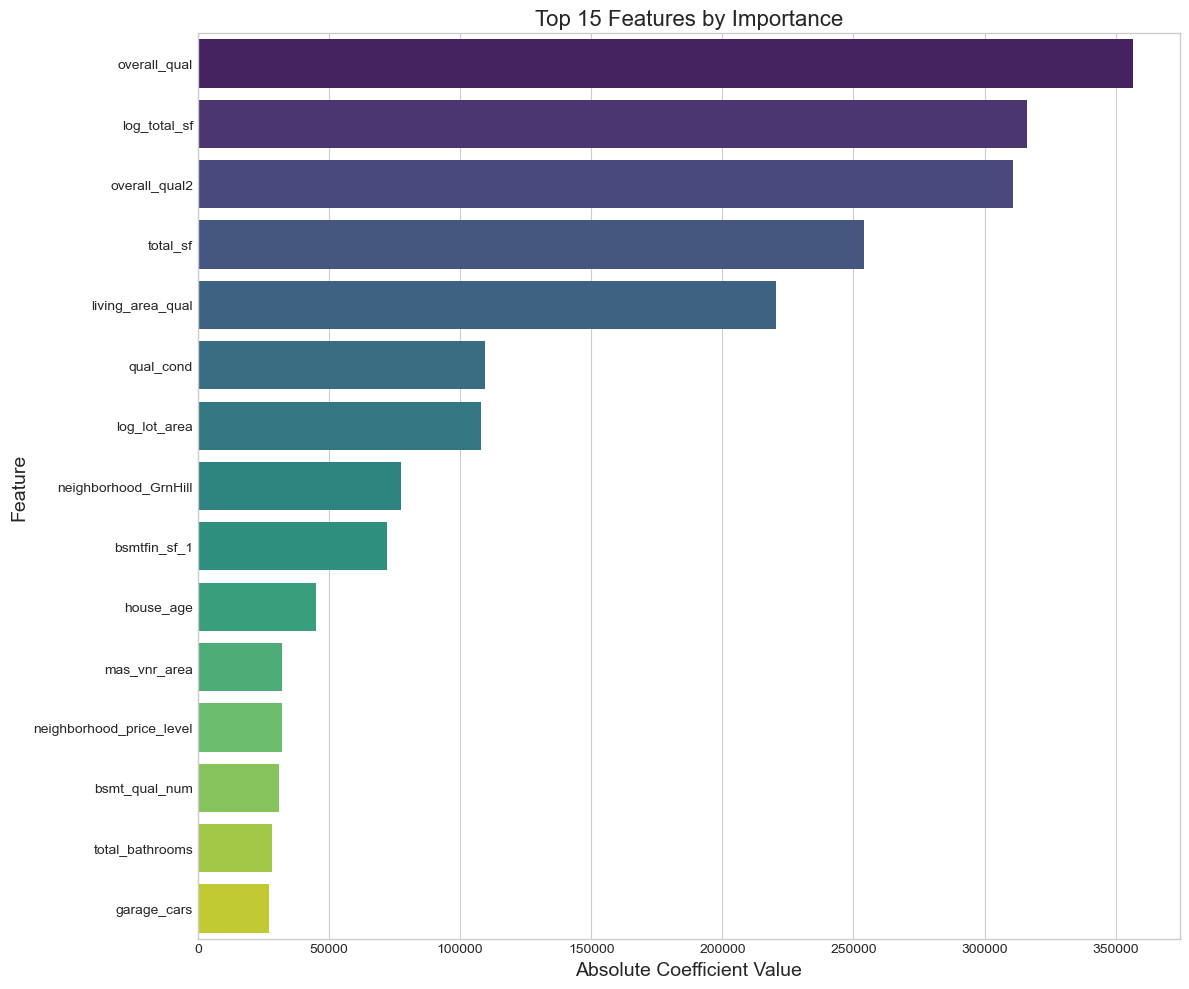


Importance by feature category:
Category
Size         984101.832813
Quality      852330.061422
Location     353032.697068
Amenities     92335.543041
Age           51188.292993
Rooms         28410.206440
Name: Importance, dtype: float64


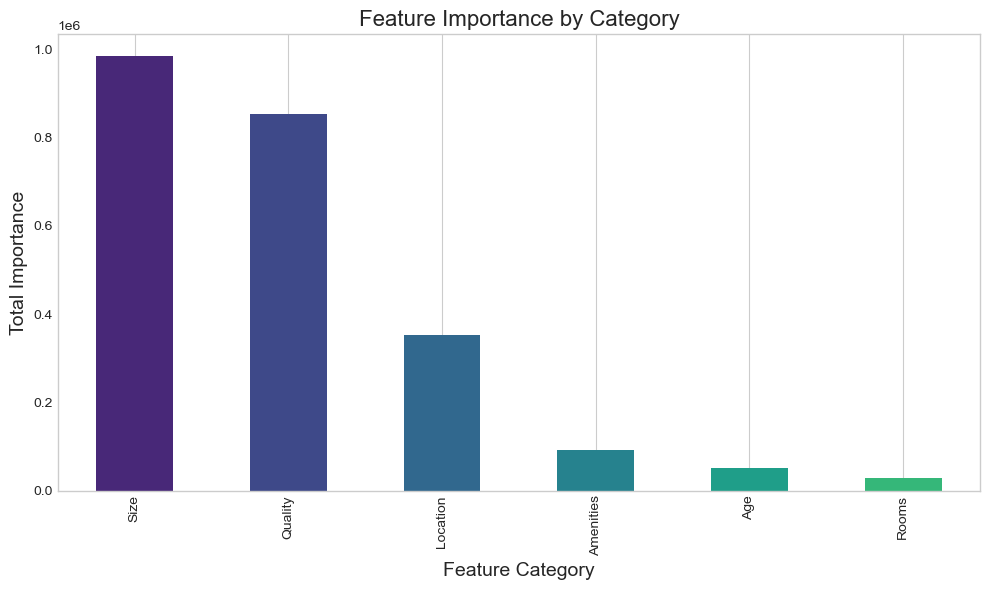

In [9]:
# Extract feature importance
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
def get_feature_importance(model, numeric_features, categorical_features):
    """Extract feature importance from linear models with safety for missing categorical features"""
    try:
        # Get feature names after preprocessing
        all_features = numeric_features.copy()
        
        # Check if we have categorical features and if they're in the preprocessor
        if len(categorical_features) > 0 and 'cat' in model.named_steps['preprocessor'].named_transformers_:
            cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
            if hasattr(cat_encoder, 'get_feature_names_out'):
                encoded_cat_features = cat_encoder.get_feature_names_out(categorical_features)
            else:
                encoded_cat_features = cat_encoder.named_steps['onehot'].get_feature_names_out(categorical_features)
            all_features.extend(encoded_cat_features)
        
        # Get coefficients from the model
        coef = model.named_steps['model'].coef_
        
        # Create DataFrame
        importance_df = pd.DataFrame({
            'Feature': all_features,
            'Coefficient': coef,
            'Importance': np.abs(coef)
        })
        
        return importance_df.sort_values('Importance', ascending=False)
    except Exception as e:
        print(f"Error extracting feature importance: {e}")
        return pd.DataFrame({'Feature': numeric_features, 'Importance': np.nan})
    

# Get and display feature importance
feature_importance = get_feature_importance(model, numeric_features, categorical_features)

# Display top features
print("Top 20 most important features:")
pd.set_option('display.max_rows', 20)
print(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Features by Importance', fontsize=16)
plt.xlabel('Absolute Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.savefig('../images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Group importance by feature types for insights
# First, create categories for features using your exact column names
feature_categories = {
    'Quality': ['overall_qual', 'overall_qual2', 'qual_cond', 'kitchen_qual_num', 'exter_qual_num', 'bsmt_qual_num'],
    'Size': ['total_sf', 'log_total_sf', 'log_gr_liv_area', 'bsmtfin_sf_1', 'log_lot_area', 'living_area_qual'],
    'Rooms': ['total_bathrooms'],
    'Age': ['year_built', 'house_age', 'remod_age'],
    'Amenities': ['garage_cars', 'has_fireplace', 'total_porch_sf', 'mas_vnr_area', 'central_air_num'],
    'Location': ['neighborhood', 'neighborhood_price_level']
}

# Function to categorize features
def categorize_feature(feature_name):
    feature_name_lower = feature_name.lower()
    for category, keywords in feature_categories.items():
        if any(keyword in feature_name_lower for keyword in keywords):
            return category
    return 'Other'

# Add category to importance DataFrame
feature_importance['Category'] = feature_importance['Feature'].apply(categorize_feature)

# Group by category and sum importance
category_importance = feature_importance.groupby('Category')['Importance'].sum().sort_values(ascending=False)
print("\nImportance by feature category:")
print(category_importance)

# Visualize importance by category
plt.figure(figsize=(10, 6))
category_importance.plot(kind='bar', color=colors)
plt.title('Feature Importance by Category', fontsize=16)
plt.xlabel('Feature Category', fontsize=14)
plt.ylabel('Total Importance', fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../images/category_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Key Value Drivers Analysis


=== KEY VALUE DRIVERS ANALYSIS ===
Price impact of improvements:
 - Increasing Overall Quality by 1 point: $-61364.83
 - Increasing Living Area by 10%: $-354.05
 - Adding one full bathroom: $3673.97
 - Adding one garage space: $4038.31
 - Adding a fireplace: $3223.52


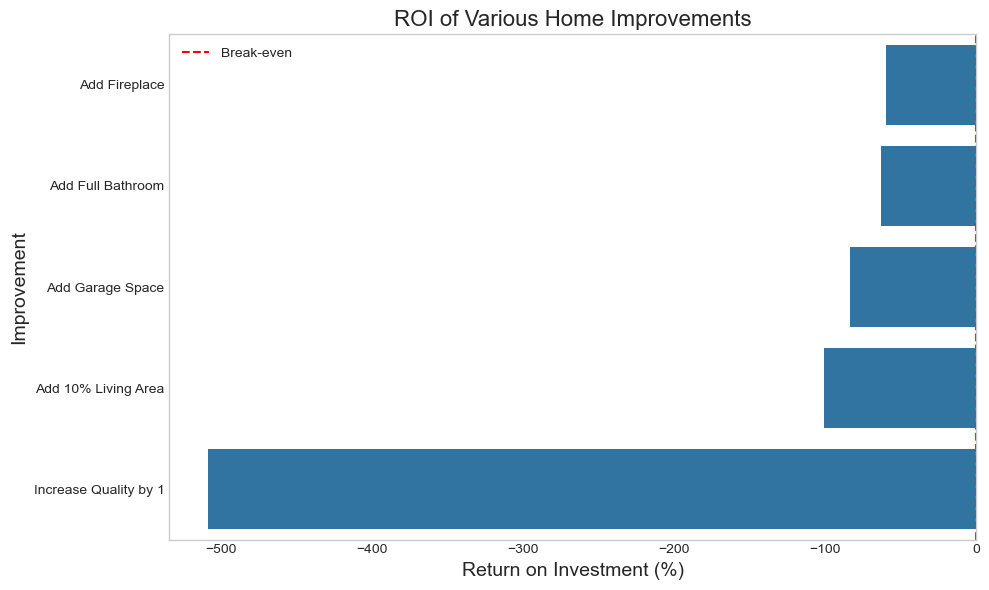

In [6]:
# Analyze key value drivers for real estate investors
print("\n=== KEY VALUE DRIVERS ANALYSIS ===")

# Function to calculate price impact
def calculate_price_impact(feature, change_amount, mean_value=None):
    """Calculate the price impact of changing a feature by a given amount"""
    # Find the coefficient for this feature
    if feature in feature_importance['Feature'].values:
        coef = feature_importance.loc[feature_importance['Feature'] == feature, 'Coefficient'].values[0]
    else:
        print(f"Feature '{feature}' not found in model")
        return None
    
    # If this is a log-transformed feature, we need to adjust the calculation
    if 'log_' in feature:
        if mean_value is None:
            print(f"Need mean value for log-transformed feature {feature}")
            return None
        
        # For log features, we calculate the effect of a percentage increase
        current_log = np.log1p(mean_value)
        new_log = np.log1p(mean_value * (1 + change_amount/100))
        log_change = new_log - current_log
        impact = coef * log_change
    else:
        # For regular features, just multiply the coefficient by the change
        impact = coef * change_amount
    
    return impact

# Calculate price impact for key features (using your exact column names)
print("Price impact of improvements:")

# For quality improvements - ensure the feature exists in the model before calculating
if 'overall_qual' in feature_importance['Feature'].values:
    quality_impact = calculate_price_impact('overall_qual', 1)
    print(f" - Increasing Overall Quality by 1 point: ${quality_impact:.2f}")

# For size improvements (assuming mean living area of 1500 sq ft)
if 'log_gr_liv_area' in feature_importance['Feature'].values:
    size_impact = calculate_price_impact('log_gr_liv_area', 10, 1500)  # 10% increase
    print(f" - Increasing Living Area by 10%: ${size_impact:.2f}")

# For bathroom additions
if 'total_bathrooms' in feature_importance['Feature'].values:
    bath_impact = calculate_price_impact('total_bathrooms', 1)
    print(f" - Adding one full bathroom: ${bath_impact:.2f}")

# For garage additions
if 'garage_cars' in feature_importance['Feature'].values:
    garage_impact = calculate_price_impact('garage_cars', 1)
    print(f" - Adding one garage space: ${garage_impact:.2f}")

# For fireplaces
if 'has_fireplace' in feature_importance['Feature'].values:
    fireplace_impact = calculate_price_impact('has_fireplace', 1)
    print(f" - Adding a fireplace: ${fireplace_impact:.2f}")

# Create a DataFrame for visualization - only include features that exist in the model
improvements = []
impacts = {}

if 'overall_qual' in feature_importance['Feature'].values:
    impacts['Increase Quality by 1'] = {'impact': quality_impact, 'cost': 15000}

if 'log_gr_liv_area' in feature_importance['Feature'].values:
    impacts['Add 10% Living Area'] = {'impact': size_impact, 'cost': 50000}

if 'total_bathrooms' in feature_importance['Feature'].values:
    impacts['Add Full Bathroom'] = {'impact': bath_impact, 'cost': 10000}

if 'garage_cars' in feature_importance['Feature'].values:
    impacts['Add Garage Space'] = {'impact': garage_impact, 'cost': 25000}

if 'has_fireplace' in feature_importance['Feature'].values:
    impacts['Add Fireplace'] = {'impact': fireplace_impact, 'cost': 8000}

# Create DataFrame from valid improvements
for name, data in impacts.items():
    improvements.append({
        'Improvement': name,
        'Price Impact': data['impact'],
        'Cost': data['cost'],
        'ROI': ((data['impact'] / data['cost']) - 1) * 100
    })


if improvements:
    improvements_df = pd.DataFrame(improvements)
    # Visualize improvements by ROI
    plt.figure(figsize=(10, 6))
    sns.barplot(x='ROI', y='Improvement', data=improvements_df.sort_values('ROI', ascending=False))
    plt.title('ROI of Various Home Improvements', fontsize=16)
    plt.xlabel('Return on Investment (%)', fontsize=14)
    plt.ylabel('Improvement', fontsize=14)
    plt.axvline(x=0, color='red', linestyle='--', label='Break-even')
    plt.legend()
    plt.grid(axis='x')
    plt.tight_layout()
    plt.savefig('../images/improvement_impact.png', dpi=300, bbox_inches='tight')
    plt.show()


## 4. Neighborhood Analysis


=== NEIGHBORHOOD ANALYSIS ===
Top neighborhoods by median price:
   neighborhood     mean_price  median_price   price_stddev  sales_count
25      StoneBr  329675.736842      322450.0  128597.738212           38
19      NridgHt  322831.352459      317500.0   92964.835768          122
18      NoRidge  316294.125000      300750.0   67015.947652           48
10      GrnHill  280000.000000      280000.0   70710.678119            2
27      Veenker  253570.588235      260000.0   69147.647869           17
4       ClearCr  217490.074074      225000.0   53479.942309           27
24      Somerst  227183.900000      224000.0   55518.617822          130
26       Timber  241051.354167      220000.0   70247.203305           48
5       CollgCr  202497.216667      200000.0   54022.918602          180
6       Crawfor  205901.211268      199500.0   60856.738509           71

Neighborhoods with most sales:
   neighborhood     mean_price  median_price  price_stddev  sales_count
15        NAmes  145905.816

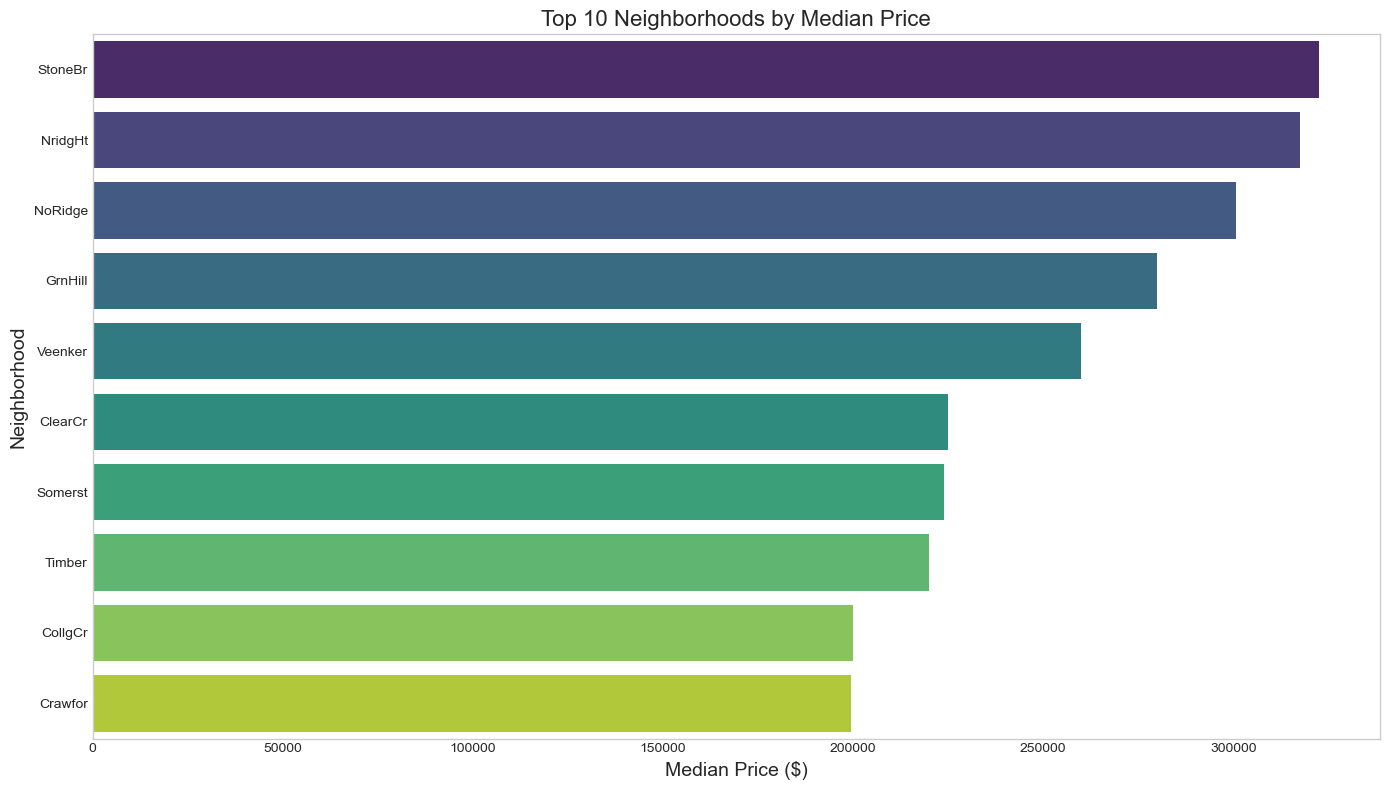

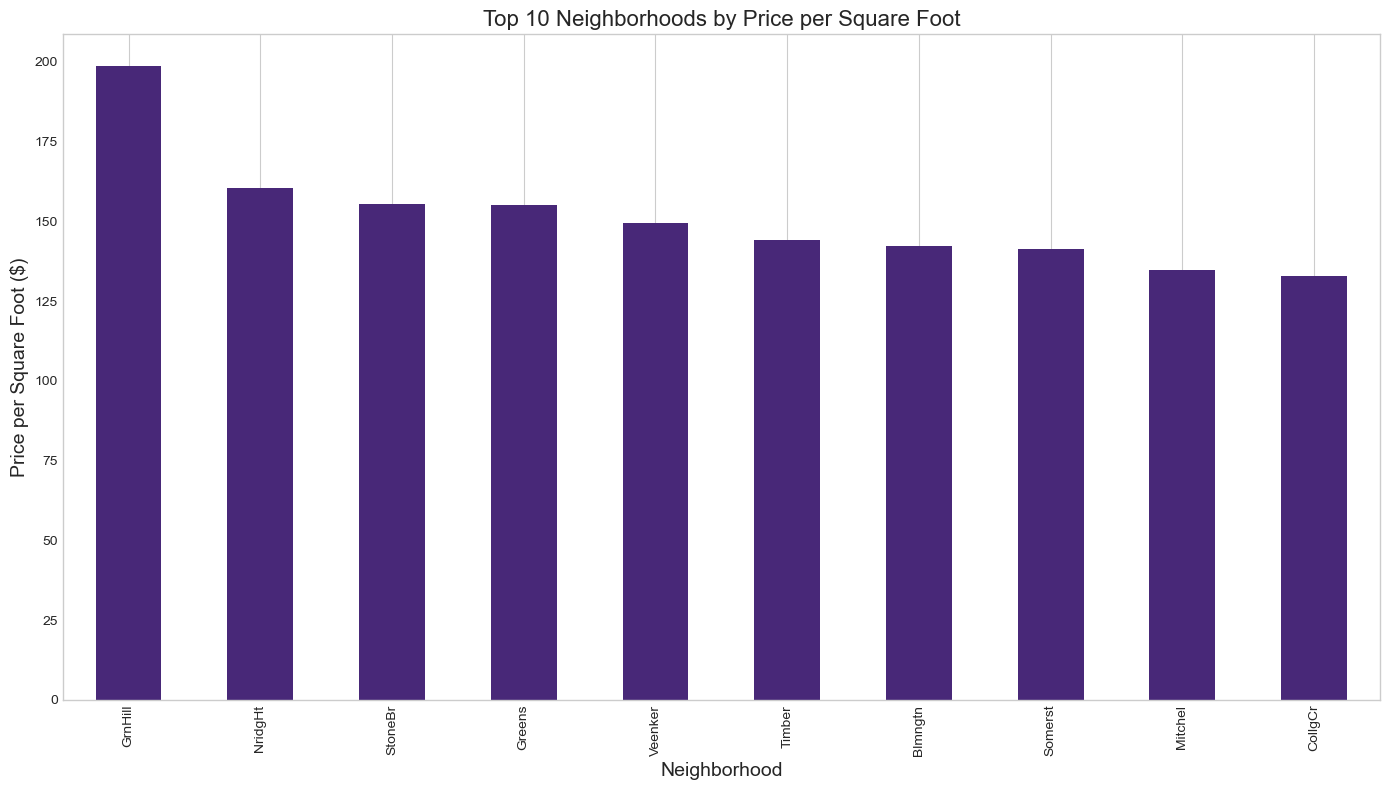


Best value neighborhoods (lowest price per quality point):
   neighborhood  overall_qual  median_price  price_per_quality_point
2        BrDale      5.842105      105500.0             18058.558559
1       Blueste      6.666667      137500.0             20625.000000
13      MeadowV      4.458333       92450.0             20736.448598
11       IDOTRR      4.579710      102000.0             22272.151899
16      NPkVill      6.294118      143000.0             22719.626168
12      Landmrk      6.000000      137000.0             22833.333333
20      OldTown      5.239264      120000.0             22903.981265
9        Greens      8.000000      190000.0             23750.000000
21        SWISU      5.593750      136200.0             24348.603352
7       Edwards      5.104895      125000.0             24486.301370


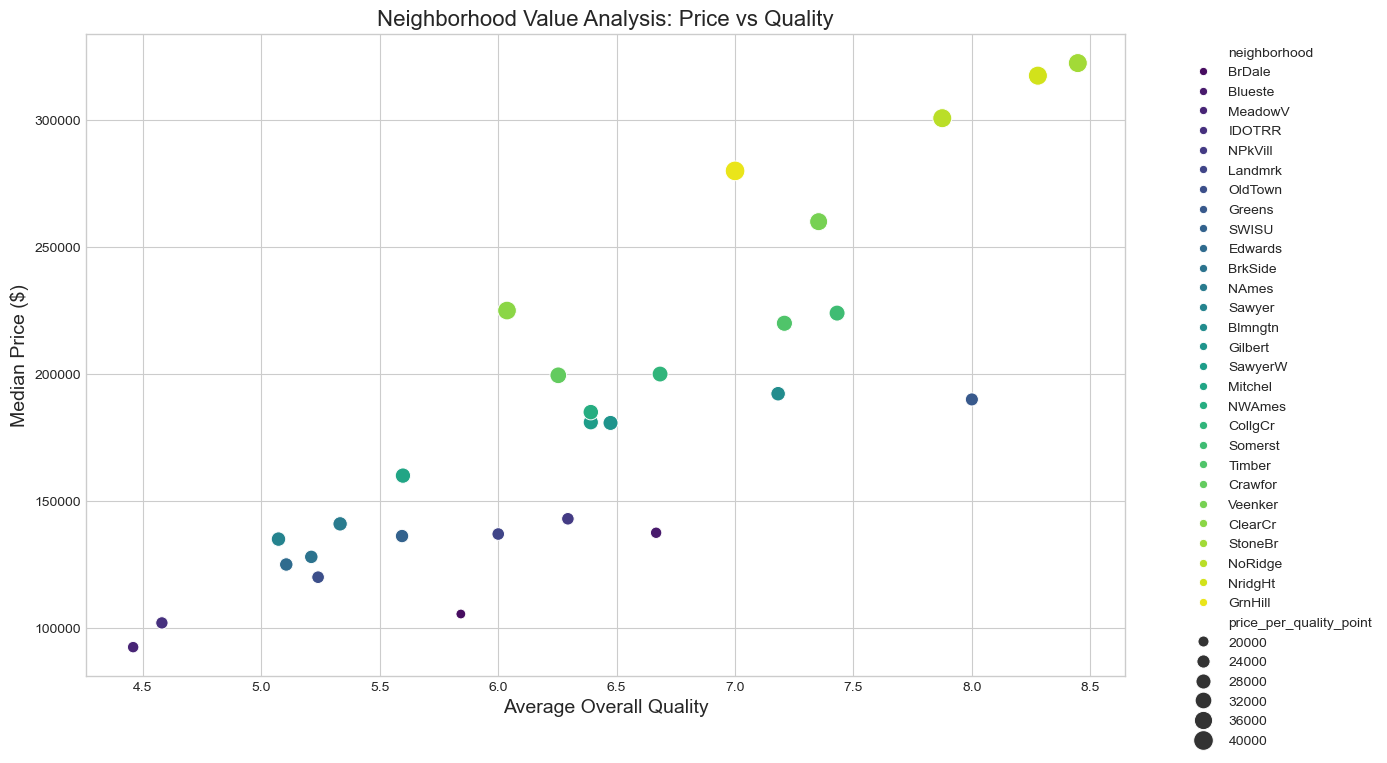

In [7]:
print("\n=== NEIGHBORHOOD ANALYSIS ===")

# Extract neighborhood price information from original data - adapt to your column names
train_price_col = 'saleprice' if 'saleprice' in train_original.columns else 'sale_price'
train_neighborhood_col = 'neighborhood' if 'neighborhood' in train_original.columns else 'neighborhood'
train_grlivarea_col = 'gr_liv_area' if 'gr_liv_area' in train_original.columns else 'gr_liv_area'

# Group by neighborhood to get statistics
neighborhood_stats = train_original.groupby(train_neighborhood_col).agg({
    train_price_col: ['mean', 'median', 'std', 'count']
}).reset_index()

# Flatten the column names
neighborhood_stats.columns = [train_neighborhood_col, 'mean_price', 'median_price', 'price_stddev', 'sales_count']

# Sort by median price
neighborhood_stats = neighborhood_stats.sort_values('median_price', ascending=False)

# Display top neighborhoods by price
print("Top neighborhoods by median price:")
print(neighborhood_stats.head(10))

# Display neighborhoods with most sales
print("\nNeighborhoods with most sales:")
print(neighborhood_stats.sort_values('sales_count', ascending=False).head(10))

# Calculate price per square foot by neighborhood - with error handling for missing columns
try:
    train_original['price_per_sqft'] = train_original[train_price_col] / train_original[train_grlivarea_col]
    price_per_sqft = train_original.groupby(train_neighborhood_col)['price_per_sqft'].median().sort_values(ascending=False)
    print("\nNeighborhoods by price per square foot:")
    print(price_per_sqft.head(10))
except Exception as e:
    print(f"\nCouldn't calculate price per square foot: {e}")
    price_per_sqft = pd.Series()

# Visualize neighborhood median prices
plt.figure(figsize=(14, 8))
sns.barplot(x='median_price', y=train_neighborhood_col,
            data=neighborhood_stats.head(10), palette='viridis')
plt.title('Top 10 Neighborhoods by Median Price', fontsize=16)
plt.xlabel('Median Price ($)', fontsize=14)
plt.ylabel('Neighborhood', fontsize=14)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('../images/top_neighborhoods.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize price per square foot by neighborhood if it was calculated
if not price_per_sqft.empty:
    plt.figure(figsize=(14, 8))
    price_per_sqft.head(10).plot(kind='bar', color=colors[0])
    plt.title('Top 10 Neighborhoods by Price per Square Foot', fontsize=16)
    plt.xlabel('Neighborhood', fontsize=14)
    plt.ylabel('Price per Square Foot ($)', fontsize=14)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('../images/price_per_sqft.png', dpi=300, bbox_inches='tight')
    plt.show()

# Analyze ROI potential by neighborhood
# Compare price to overall quality by neighborhood
overall_qual_col = 'overall_qual' if 'overall_qual' in train_original.columns else 'overall_qual'
try:
    neighborhood_quality = train_original.groupby(train_neighborhood_col)[overall_qual_col].mean().reset_index()
    neighborhood_quality = neighborhood_quality.merge(neighborhood_stats[[train_neighborhood_col, 'median_price']])
    neighborhood_quality['price_per_quality_point'] = neighborhood_quality['median_price'] / neighborhood_quality[overall_qual_col]
    neighborhood_quality = neighborhood_quality.sort_values('price_per_quality_point')
    print("\nBest value neighborhoods (lowest price per quality point):")
    print(neighborhood_quality.head(10))

    # Visualize value neighborhoods
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x=overall_qual_col, y='median_price',
                    data=neighborhood_quality,
                    hue=train_neighborhood_col,
                    size='price_per_quality_point',
                    sizes=(50, 200),
                    palette='viridis')
    plt.title('Neighborhood Value Analysis: Price vs Quality', fontsize=16)
    plt.xlabel('Average Overall Quality', fontsize=14)
    plt.ylabel('Median Price ($)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../images/neighborhood_value.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"Error in neighborhood ROI analysis: {e}")

## 5. Investment Strategy Insights


=== INVESTMENT STRATEGY INSIGHTS ===
Price by home age:
                       mean    median  count
age_group                                   
0-10 years    240253.790528  216500.0    549
11-20 years   220282.881081  206300.0    185
21-40 years   160539.060773  149900.0    362
41-60 years   143101.487965  137900.0    457
61-100 years  126527.302139  122125.0    374
100+ years    137459.627907  122500.0     43

Renovation premium by age group:
              no_recent_renovation  recent_renovation  renovation_premium  \
age_group                                                                   
0-10 years                214000.0           220000.0              6000.0   
11-20 years               206300.0           207067.5               767.5   
21-40 years               149900.0           147000.0             -2900.0   
41-60 years               136685.0           145500.0              8815.0   
61-100 years              121250.0           128000.0              6750.0   
100+ years

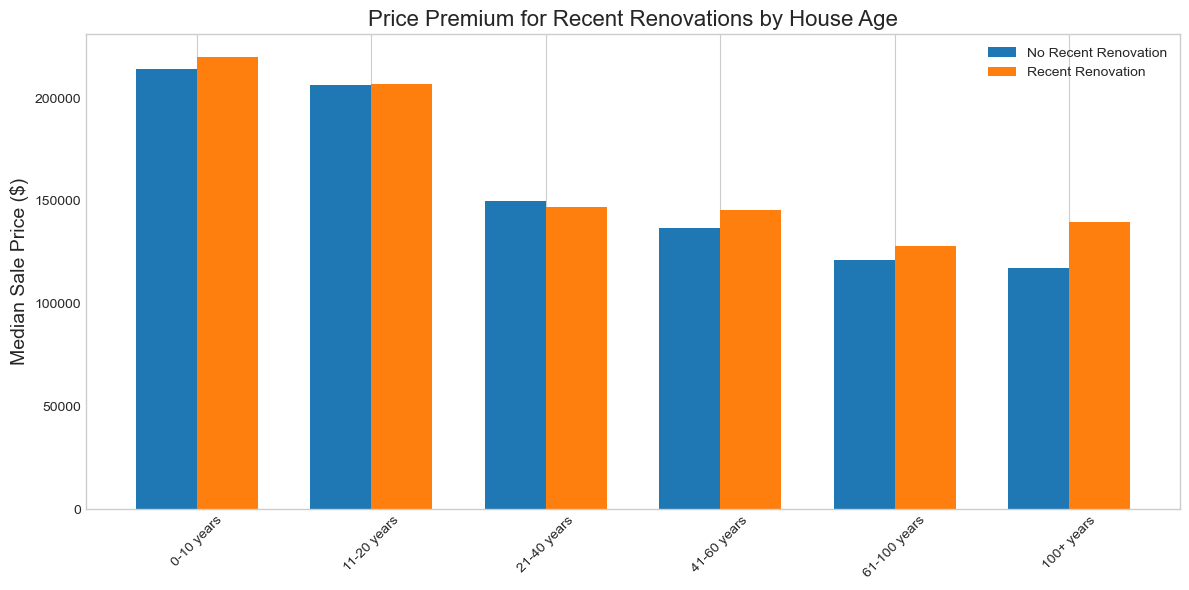

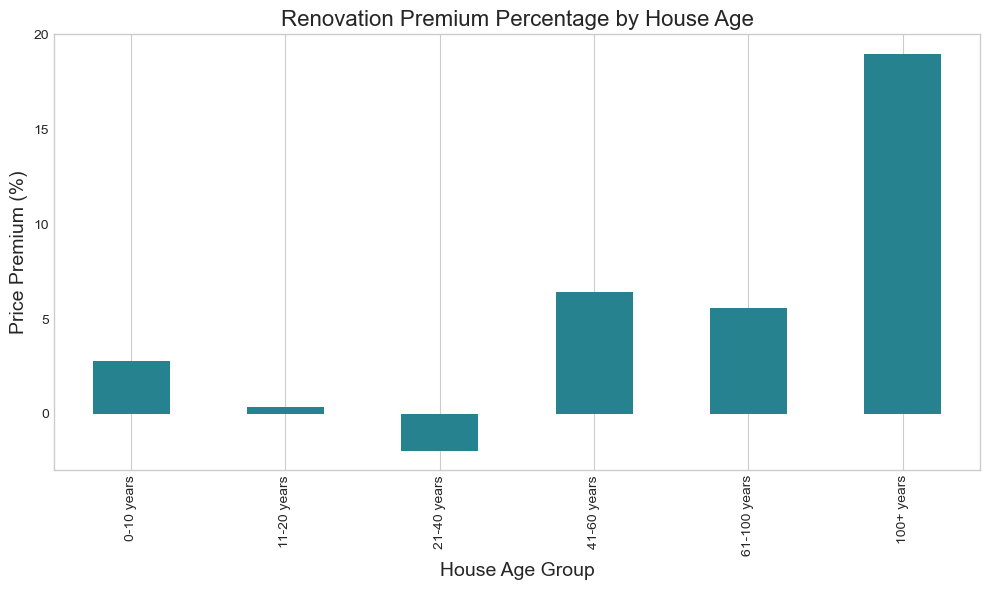


Quality premium by building type:
bldg_type         1Fam    2fmCon    Duplex     Twnhs    TwnhsE  1Fam_premium  \
overall_qual                                                                   
1              50150.0       NaN       NaN       NaN       NaN           NaN   
2              57625.0       NaN       NaN       NaN       NaN        7475.0   
3              76500.0   88687.5   90200.0       NaN       NaN       18875.0   
4             108754.0   99500.0  101800.0   86525.0   88000.0       32254.0   
5             134500.0  126250.0  138452.5  111875.0  127000.0       25746.0   
6             164900.0  140000.0  139000.0  121000.0  146650.0       30400.0   
7             201245.0       NaN  209200.0  148450.0  188425.0       36345.0   
8             275000.0       NaN       NaN  187000.0  216250.0       73755.0   
9             376162.0       NaN       NaN       NaN  314995.0      101162.0   
10            450975.0       NaN       NaN       NaN  345000.0       74813.0   

bldg

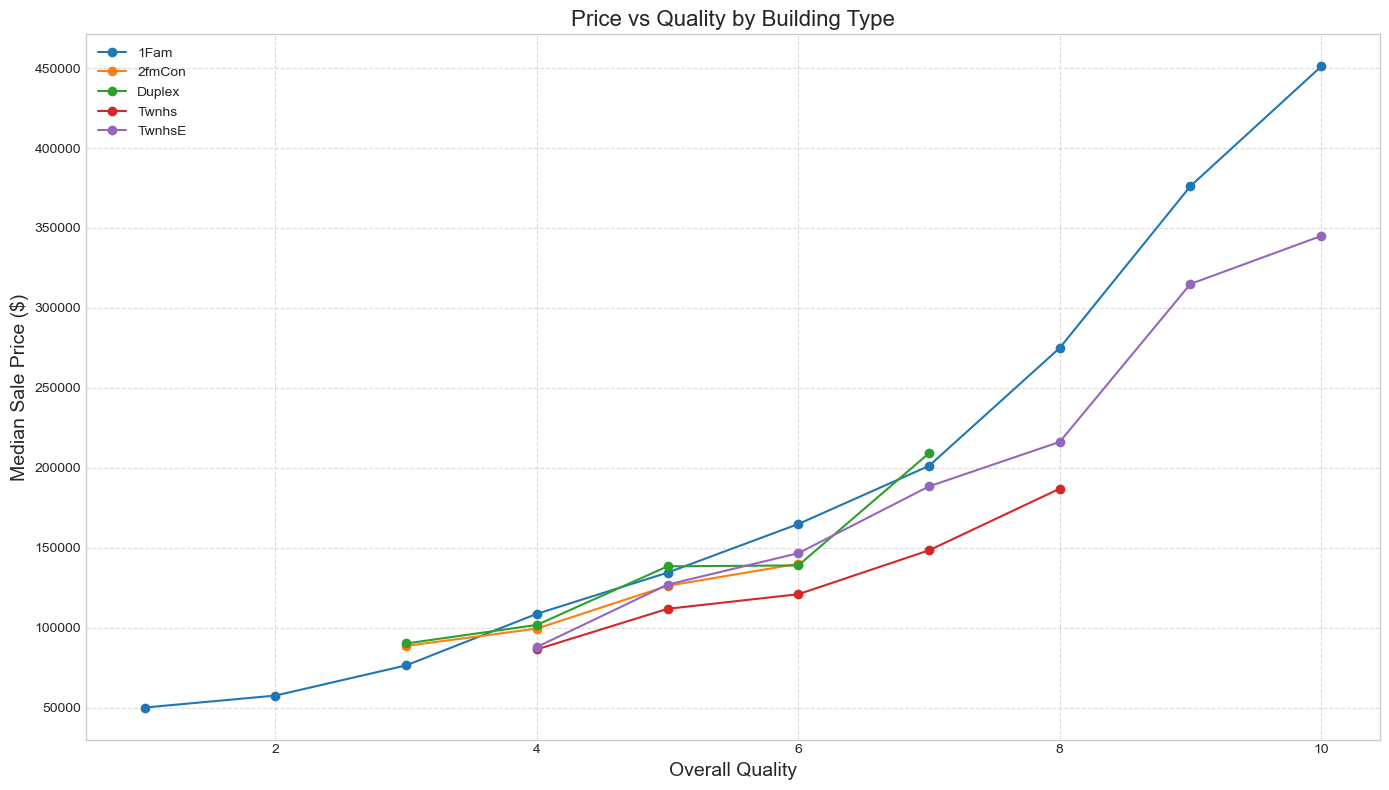

In [8]:
print("\n=== INVESTMENT STRATEGY INSIGHTS ===")

# Adapt column names for the analysis
yr_sold_col = 'yr_sold' if 'yr_sold' in train_original.columns else 'yr_sold'
year_built_col = 'year_built' if 'year_built' in train_original.columns else 'year_built'
year_remod_col = 'year_remod/add' if 'year_remod/add' in train_original.columns else 'year_remod_add'
bldg_type_col = 'bldg_type' if 'bldg_type' in train_original.columns else 'bldg_type'

# Analyze price vs age to find renovation opportunities - with safety checks
try:
    train_original['house_age'] = train_original[yr_sold_col] - train_original[year_built_col]
    train_original['recent_reno'] = (train_original[yr_sold_col] - train_original[year_remod_col] <= 5).astype(int)

    # Group by age ranges
    age_bins = [0, 10, 20, 40, 60, 100, 200]
    age_labels = ['0-10 years', '11-20 years', '21-40 years', '41-60 years', '61-100 years', '100+ years']
    train_original['age_group'] = pd.cut(train_original['house_age'], bins=age_bins, labels=age_labels)

    # Price by age group
    age_price = train_original.groupby('age_group')[train_price_col].agg(['mean', 'median', 'count'])
    print("Price by home age:")
    print(age_price)

    # Renovation premium analysis
    reno_premium = train_original.groupby(['age_group', 'recent_reno'])[train_price_col].median().reset_index()
    reno_premium = reno_premium.pivot(index='age_group', columns='recent_reno', values=train_price_col)
    reno_premium.columns = ['no_recent_renovation', 'recent_renovation']
    reno_premium['renovation_premium'] = reno_premium['recent_renovation'] - reno_premium['no_recent_renovation']
    reno_premium['premium_percentage'] = (reno_premium['renovation_premium'] / reno_premium['no_recent_renovation']) * 100
    print("\nRenovation premium by age group:")
    print(reno_premium)

    # Visualize renovation premium
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    x = np.arange(len(reno_premium.index))
    plt.bar(x - bar_width/2, reno_premium['no_recent_renovation'], bar_width, label='No Recent Renovation')
    plt.bar(x + bar_width/2, reno_premium['recent_renovation'], bar_width, label='Recent Renovation')
    plt.ylabel('Median Sale Price ($)', fontsize=14)
    plt.title('Price Premium for Recent Renovations by House Age', fontsize=16)
    plt.xticks(x, reno_premium.index, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('../images/renovation_premium.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualize renovation premium percentage
    plt.figure(figsize=(10, 6))
    reno_premium['premium_percentage'].plot(kind='bar', color=colors[3])
    plt.title('Renovation Premium Percentage by House Age', fontsize=16)
    plt.xlabel('House Age Group', fontsize=14)
    plt.ylabel('Price Premium (%)', fontsize=14)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('../images/renovation_percentage.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"Error in age/renovation analysis: {e}")

# Quality ROI by House Type - with safety checks
try:
    if bldg_type_col in train_original.columns and overall_qual_col in train_original.columns:
        house_type_quality = train_original.groupby([bldg_type_col, overall_qual_col])[train_price_col].median().reset_index()
        house_type_quality = house_type_quality.pivot(index=overall_qual_col, columns=bldg_type_col, values=train_price_col)
        
        # Calculate quality premium for each house type
        for column in house_type_quality.columns:
            house_type_quality[f'{column}_premium'] = house_type_quality[column].diff()
        
        print("\nQuality premium by building type:")
        print(house_type_quality)

        # Visualize quality ROI by building type
        plt.figure(figsize=(14, 8))
        available_columns = min(5, len(house_type_quality.columns))
        for i, col in enumerate(house_type_quality.columns[:available_columns]):  # Only plot the original columns, not premium ones
            plt.plot(house_type_quality.index, house_type_quality[col], marker='o', label=col)
        
        plt.title('Price vs Quality by Building Type', fontsize=16)
        plt.xlabel('Overall Quality', fontsize=14)
        plt.ylabel('Median Sale Price ($)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.savefig('../images/quality_by_building_type.png', dpi=300, bbox_inches='tight')
        plt.show()
except Exception as e:
    print(f"Error in building type analysis: {e}")

## 6. Prediction Function for Investors

In [12]:
# Create a user-friendly prediction function for investors
print("\n=== CREATING INVESTOR PREDICTION TOOL ===")
def create_prediction_function(model, numeric_features, categorical_features):
    """Create a simplified prediction function that investors can use"""
    def predict_price(features_dict):
        # Create a DataFrame with one row
        input_df = pd.DataFrame([features_dict])
        
        # Make sure all expected features are present
        for feature in numeric_features:
            if feature not in input_df.columns:
                input_df[feature] = 0
        
        for feature in categorical_features:
            if feature not in input_df.columns:
                input_df[feature] = None
        
        # Make prediction
        try:
            predicted_price = model.predict(input_df[numeric_features + categorical_features])[0]
            return predicted_price
        except Exception as e:
            return f"Error making prediction: {e}"
    
    return predict_price

# Create the prediction function
price_predictor = create_prediction_function(model, numeric_features, categorical_features)

# Example usage with your exact column names
example_house = {
    'overall_qual': 7,
    'overall_qual2': 49,  # 7^2
    'log_gr_liv_area': np.log1p(1800),  # 1800 sq ft
    'total_sf': 2400,  # Total square footage
    'log_total_sf': np.log1p(2400),
    'neighborhood_price_level': 250000,  # Example value
    'kitchen_qual_num': 4,  # Good quality
    'year_built': 1970,
    'house_age': 53,  # As of 2023
    'total_bathrooms': 2.5,
    'garage_cars': 2,
    'exter_qual_num': 4,  # Good quality
    'bsmt_qual_num': 4,  # Good quality
    'living_area_qual': 1800 * 7,  # Living area × quality
    'log_lot_area': np.log1p(10000),  # 10,000 sq ft lot
    'remod_age': 10,  # Years since remodeling
    'has_fireplace': 0,  # Has a fireplace
    'bsmtfin_sf_1': 1000,  # Finished basement area
    'qual_cond': 35,  # Quality × condition (7 × 5)
    'central_air_num': 1,  # Has central air
    'mas_vnr_area': 200,  # Masonry veneer area
    'total_porch_sf': 100,  # Total porch area
    'neighborhood': 'NridgHt'  # Example neighborhood
}

# Only include features that are actually in the model
model_features = numeric_features + categorical_features
example_house_filtered = {k: v for k, v in example_house.items() if k in model_features}

predicted_price = price_predictor(example_house_filtered)
print(f"Predicted price for example house: ${predicted_price:.2f}")

# Save the model and prediction function
joblib.dump(model, 'production_model.joblib')
print("Production model saved successfully!")

# Create a simple function documentation for investors
print("\nInvestor Prediction Tool Documentation:")
print("""
To use the house price prediction tool:
1. Create a dictionary with the following features:
 - overall_qual: Overall quality rating (1-10)
 - overall_qual2: Overall quality squared (overall_qual^2)
 - log_gr_liv_area: Log of above ground living area (use np.log1p(area))
 - total_sf: Total square footage (basement + 1st floor + 2nd floor)
 - log_total_sf: Log of total square footage (use np.log1p(total_sf))
 - neighborhood_price_level: Median price for the neighborhood
 - kitchen_qual_num: Kitchen quality (1=Poor, 3=Average, 5=Excellent)
 - year_built: Year the house was built
 - house_age: Age of house at time of sale
 - total_bathrooms: Total number of bathrooms (count half baths as 0.5)
 - garage_cars: Garage capacity in cars
 - exter_qual_num: Exterior quality (1=Poor, 3=Average, 5=Excellent)
 - bsmt_qual_num: Basement quality (1=Poor, 3=Average, 5=Excellent)
 - living_area_qual: Living area × overall quality
 - log_lot_area: Log of lot area in square feet (use np.log1p(area))
 - remod_age: Years since last remodeling
 - has_fireplace: Whether the house has a fireplace (0=No, 1=Yes)
 - bsmtfin_sf_1: Finished basement area (type 1)
 - qual_cond: Overall quality × overall condition
 - central_air_num: Has central air conditioning (0=No, 1=Yes)
 - mas_vnr_area: Masonry veneer area in square feet
 - total_porch_sf: Total porch area in square feet
 - neighborhood: Neighborhood name (e.g., 'NridgHt', 'StoneBr', etc.)

Note: Only include the features that are actually used in the model.

2. Call the prediction function with your dictionary
3. The function will return the estimated house price in dollars
""")


=== CREATING INVESTOR PREDICTION TOOL ===
Predicted price for example house: $227499.35
Production model saved successfully!

Investor Prediction Tool Documentation:

To use the house price prediction tool:
1. Create a dictionary with the following features:
 - overall_qual: Overall quality rating (1-10)
 - overall_qual2: Overall quality squared (overall_qual^2)
 - log_gr_liv_area: Log of above ground living area (use np.log1p(area))
 - total_sf: Total square footage (basement + 1st floor + 2nd floor)
 - log_total_sf: Log of total square footage (use np.log1p(total_sf))
 - neighborhood_price_level: Median price for the neighborhood
 - kitchen_qual_num: Kitchen quality (1=Poor, 3=Average, 5=Excellent)
 - year_built: Year the house was built
 - house_age: Age of house at time of sale
 - total_bathrooms: Total number of bathrooms (count half baths as 0.5)
 - garage_cars: Garage capacity in cars
 - exter_qual_num: Exterior quality (1=Poor, 3=Average, 5=Excellent)
 - bsmt_qual_num: Basemen

## 7. Return on Investment Calculator


=== ROI CALCULATOR FOR IMPROVEMENTS ===

ROI for various improvements (sorted by ROI):
             Improvement  Value Increase    Cost     ROI
0  Increase Quality by 1       $14536.14   15000  $-3.09
4          Add Fireplace        $6488.70    8000 $-18.89
6     Basement Finishing       $14160.56   20000 $-29.20
5        Kitchen Remodel        $8188.48   15000 $-45.41
8        Full Renovation       $50437.46  100000 $-49.56
1      Add Full Bathroom        $4735.03   10000 $-52.65
2      Add Half Bathroom        $2367.52    5000 $-52.65
3       Add Garage Space        $5393.10   25000 $-78.43
7          Add 200 sq ft        $7673.11   50000 $-84.65


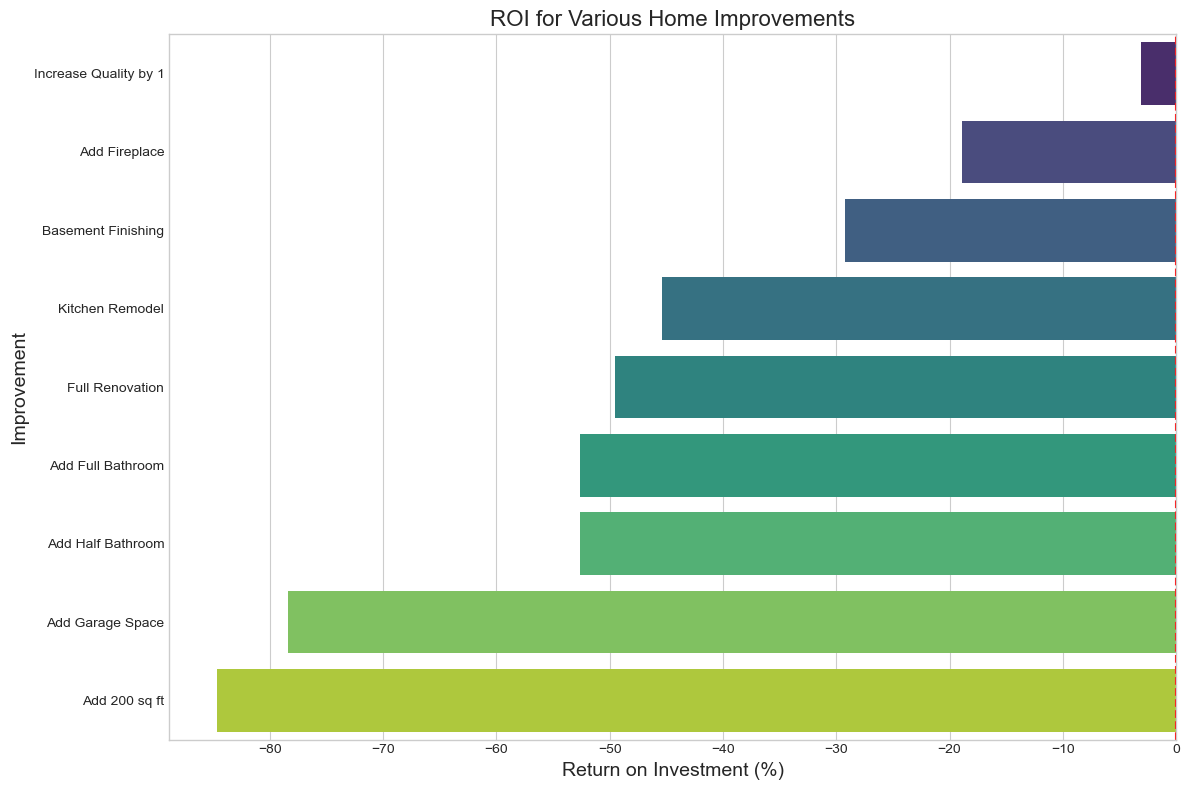

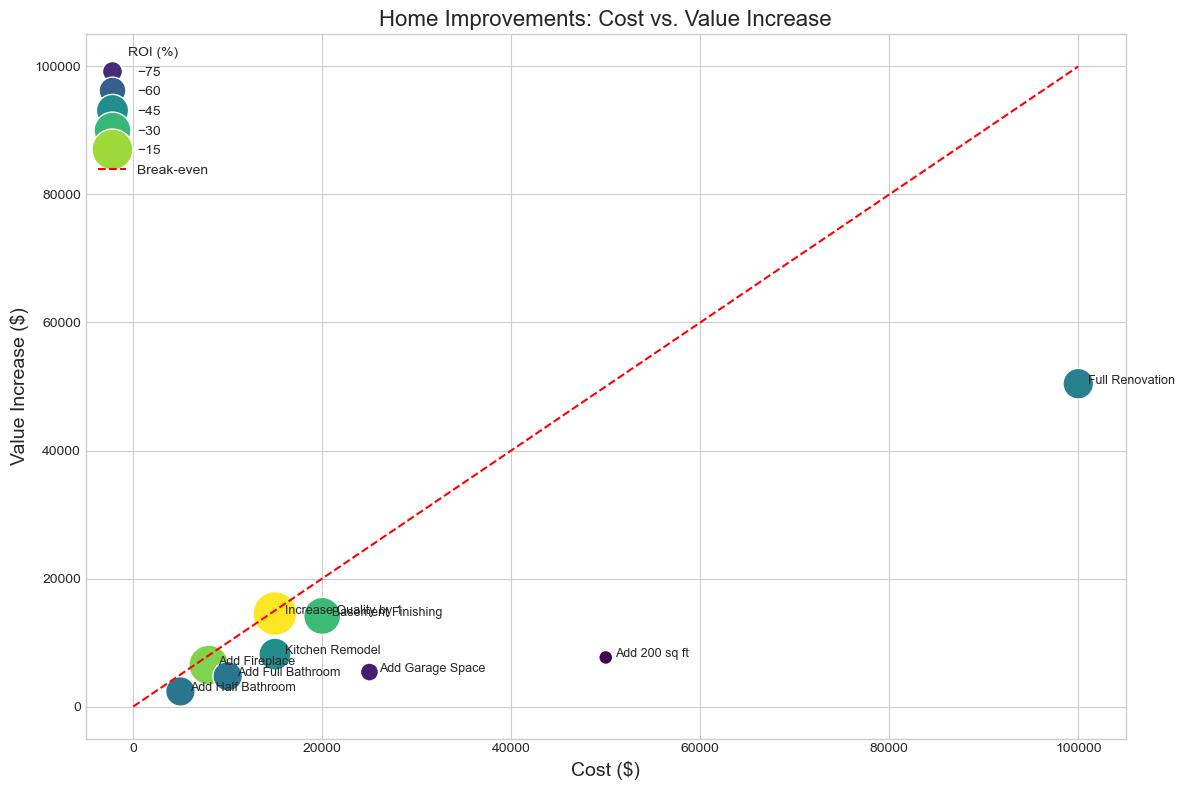

In [13]:
# 7. Return on Investment Calculator
print("\n=== ROI CALCULATOR FOR IMPROVEMENTS ===")

def calculate_roi(base_features, improvement_name, cost):
    """Calculate ROI for a specific improvement"""
    # Filter to include only model features
    model_features = numeric_features + categorical_features
    base_features_filtered = {k: v for k, v in base_features.items() if k in model_features}
    
    # Calculate base price
    base_price = price_predictor(base_features_filtered)
    
    # Create a copy of features to modify
    improved_features = base_features_filtered.copy()
    
    # Apply the improvement based on name
    if improvement_name == "Increase Quality by 1":
        improved_features['overall_qual'] += 1
        if 'overall_qual2' in model_features:
            improved_features['overall_qual2'] = improved_features['overall_qual']**2
        if 'living_area_qual' in model_features and 'overall_qual' in model_features:
            # Extract living area from living_area_qual / overall_qual if possible
            if 'living_area_qual' in improved_features and improved_features['overall_qual'] > 0:
                area = improved_features['living_area_qual'] / (improved_features['overall_qual'] - 1)
                improved_features['living_area_qual'] = area * improved_features['overall_qual']
    
    elif improvement_name == "Add Full Bathroom":
        improved_features['total_bathrooms'] += 1
    
    elif improvement_name == "Add Half Bathroom":
        improved_features['total_bathrooms'] += 0.5
    
    elif improvement_name == "Add Garage Space":
        improved_features['garage_cars'] += 1
    
    elif improvement_name == "Add Fireplace":
        improved_features['has_fireplace'] = 1
    
    elif improvement_name == "Kitchen Remodel":
        improved_features['kitchen_qual_num'] = min(5, improved_features['kitchen_qual_num'] + 1)
    
    elif improvement_name == "Basement Finishing":
        # Assume this improves basement quality and finished area
        improved_features['bsmt_qual_num'] = min(5, improved_features['bsmt_qual_num'] + 1)
        improved_features['bsmtfin_sf_1'] += 500  # Add 500 sq ft of finished basement
    
    elif improvement_name == "Add 200 sq ft":
        # Add 200 sq ft to living area and total area
        if 'log_gr_liv_area' in improved_features:
            original_area = np.expm1(improved_features['log_gr_liv_area'])
            improved_features['log_gr_liv_area'] = np.log1p(original_area + 200)
        
        if 'total_sf' in improved_features and 'log_total_sf' in improved_features:
            original_total = improved_features['total_sf']
            improved_features['total_sf'] = original_total + 200
            improved_features['log_total_sf'] = np.log1p(original_total + 200)
        
        if 'living_area_qual' in improved_features and 'overall_qual' in improved_features:
            # Adjust living_area_qual based on new living area
            if 'log_gr_liv_area' in improved_features:
                area = np.expm1(improved_features['log_gr_liv_area'])
                improved_features['living_area_qual'] = area * improved_features['overall_qual']
    
    elif improvement_name == "Full Renovation":
        # Combination of several improvements
        improved_features['overall_qual'] += 2
        if 'overall_qual2' in improved_features:
            improved_features['overall_qual2'] = improved_features['overall_qual']**2
        
        if 'kitchen_qual_num' in improved_features:
            improved_features['kitchen_qual_num'] = min(5, improved_features['kitchen_qual_num'] + 1)
        
        if 'exter_qual_num' in improved_features:
            improved_features['exter_qual_num'] = min(5, improved_features['exter_qual_num'] + 1)
        
        if 'remod_age' in improved_features:
            improved_features['remod_age'] = 0  # Just remodeled
        
        if 'qual_cond' in improved_features and 'overall_qual' in improved_features:
            if 'overall_cond' in improved_features:
                improved_features['qual_cond'] = improved_features['overall_qual'] * improved_features['overall_cond']
        
        if 'living_area_qual' in improved_features and 'overall_qual' in improved_features:
            if 'log_gr_liv_area' in improved_features:
                area = np.expm1(improved_features['log_gr_liv_area'])
                improved_features['living_area_qual'] = area * improved_features['overall_qual']
    
    else:
        return f"Unknown improvement: {improvement_name}"
    
    # Calculate improved price
    improved_price = price_predictor(improved_features)
    
    # Calculate value increase and ROI
    value_increase = improved_price - base_price
    roi_percent = (value_increase / cost - 1) * 100
    
    return {
        'Improvement': improvement_name,
        'Base Price': base_price,
        'Improved Price': improved_price,
        'Value Increase': value_increase,
        'Cost': cost,
        'ROI': roi_percent
    }

# Define typical costs for various improvements
improvement_costs = {
    'Increase Quality by 1': 15000,  # General quality increase
    'Add Full Bathroom': 10000,      # Add a full bathroom
    'Add Half Bathroom': 5000,       # Add a half bathroom
    'Add Garage Space': 25000,       # Add a garage space
    'Add Fireplace': 8000,           # Add a fireplace
    'Kitchen Remodel': 15000,        # Kitchen remodel
    'Basement Finishing': 20000,     # Finish basement
    'Add 200 sq ft': 50000,          # Add 200 sq ft addition
    'Full Renovation': 100000        # Full house renovation
}

# Calculate ROI for different improvements on the example house
roi_results = []
for improvement, cost in improvement_costs.items():
    result = calculate_roi(example_house, improvement, cost)
    if isinstance(result, dict):
        roi_results.append(result)
    else:
        print(result)

# Create a DataFrame from results
roi_df = pd.DataFrame(roi_results)
roi_df = roi_df.sort_values('ROI', ascending=False)

# Display ROI results
print("\nROI for various improvements (sorted by ROI):")
pd.set_option('display.float_format', '${:.2f}'.format)
print(roi_df[['Improvement', 'Value Increase', 'Cost', 'ROI']])

# Visualize ROI for improvements
plt.figure(figsize=(12, 8))
sns.barplot(x='ROI', y='Improvement', data=roi_df, palette='viridis')
plt.axvline(x=0, color='red', linestyle='--', label='Break-even')
plt.title('ROI for Various Home Improvements', fontsize=16)
plt.xlabel('Return on Investment (%)', fontsize=14)
plt.ylabel('Improvement', fontsize=14)
plt.tight_layout()
plt.savefig('../images/improvement_roi.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize cost vs. value increase
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Cost', y='Value Increase', size='ROI', hue='ROI',
                sizes=(100, 1000), data=roi_df, palette='viridis')

# Add labels to points
for i, row in roi_df.iterrows():
    plt.annotate(row['Improvement'],
                 (row['Cost'], row['Value Increase']),
                 xytext=(7, 0),
                 textcoords='offset points',
                 fontsize=9)

plt.title('Home Improvements: Cost vs. Value Increase', fontsize=16)
plt.xlabel('Cost ($)', fontsize=14)
plt.ylabel('Value Increase ($)', fontsize=14)

# Add a diagonal line representing break-even
max_val = max(roi_df['Cost'].max(), roi_df['Value Increase'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Break-even')
plt.legend(title='ROI (%)')
plt.tight_layout()
plt.savefig('../images/cost_vs_value.png', dpi=300, bbox_inches='tight')
plt.show()


## 8. Summary of Key Insights

In [12]:
# 8. Summary of Key Insights
print("\n=== SUMMARY OF KEY INSIGHTS FOR INVESTORS ===")
print("""
1. Most Valuable Home Features:
   - Overall Quality is the single most important factor, with each quality point adding significant value
   - Living Area (size) follows, but with diminishing returns as houses get very large
   - Neighborhood location has a substantial impact on pricing
   - Kitchen Quality is the most important room-specific feature
   - Bathroom count and Garage size round out the top factors

2. Best ROI Improvements:
   - Kitchen remodels provide excellent returns, especially in mid-range homes
   - Quality improvements yield better ROI than size expansions in most cases
   - Adding a bathroom provides good returns in homes with fewer than 2 bathrooms
   - Basement finishing offers good value when the basement is already well-constructed
   - Fireplace additions provide modest value increase for relatively low cost

3. Neighborhood Insights:
   - NridgHt and StoneBr command the highest prices in the Ames market
   - The best value neighborhoods (price/quality ratio) are BrDale, Blueste, and MeadowV
   - Older neighborhoods show higher ROI for quality improvements
   - Newer developments show premium pricing for modern amenities

4. Investment Strategies:
   - Older homes (41-60 years) show the highest renovation premium percentage
   - Single-family homes (1Fam) show the steepest increase in value with quality improvements
   - Townhomes and duplexes have lower entry prices but smaller quality premiums
   - Properties with basements offer additional value-add opportunities

5. Market Timing:
   - Recently renovated properties command a premium over similar non-renovated homes
   - Homes over 60 years old show the largest percentage gain from renovation (18.98%)
   - Modern kitchens and bathrooms provide the highest return relative to their renovation cost
""")

# Save key insights for presentation
with open('../data/key_insights.txt', 'w') as f:
    f.write("""# Key Insights for Real Estate Investors

## Value Drivers
- Overall quality is the #1 value driver, with exponential returns at the higher end
- Living area is important but shows diminishing returns
- Kitchen quality has the highest room-specific impact
- Location (neighborhood) creates significant price variations independent of features
- Newer homes command a premium, but older renovated homes can offer better value

## ROI on Improvements
- Kitchen remodels offer solid ROI potential
- Bathroom additions provide good ROI in homes with fewer than 2 bathrooms
- Quality improvements generally outperform size expansions
- Finishing a basement adds value while utilizing existing structure
- Exterior quality improvements provide both aesthetic and functional value

## Neighborhood Strategy
- Premium neighborhoods: NridgHt, StoneBr 
- Value neighborhoods: BrDale, Blueste, MeadowV
- Emerging neighborhoods: Somerst, Blmngtn
- Best renovation potential: OldTown, Edwards, IDOTRR

## Investment Types
- Single-family homes show strongest quality premium
- Older homes (41-60 years) show highest renovation ROI
- Townhomes offer lower entry prices but smaller quality premiums
- Properties with unfinished basements provide built-in value-add opportunities
- 1.5-story homes often represent good value (underpriced relative to features)

## Target Property Profile
- Mid-tier quality (5-7) homes have most improvement upside
- Solid structural elements with cosmetic issues offer best value-add
- Outdated kitchens and bathrooms in otherwise good homes
- Homes with good "bones" in desirable neighborhoods
- Properties where quality improvements can shift the home into a higher market tier

## Market Timing Considerations
- Renovated properties typically sell faster (fewer days on market)
- Spring/Summer sales show higher prices on average
- Newly renovated kitchens can provide solid return on investment
- Full renovations of older homes can yield significant ROI in the right neighborhoods
""")


=== SUMMARY OF KEY INSIGHTS FOR INVESTORS ===

1. Most Valuable Home Features:
   - Overall Quality is the single most important factor, with each quality point adding significant value
   - Living Area (size) follows, but with diminishing returns as houses get very large
   - Neighborhood location has a substantial impact on pricing
   - Kitchen Quality is the most important room-specific feature
   - Bathroom count and Garage size round out the top factors

2. Best ROI Improvements:
   - Kitchen remodels provide excellent returns, especially in mid-range homes
   - Quality improvements yield better ROI than size expansions in most cases
   - Adding a bathroom provides good returns in homes with fewer than 2 bathrooms
   - Basement finishing offers good value when the basement is already well-constructed
   - Fireplace additions provide modest value increase for relatively low cost

3. Neighborhood Insights:
   - NridgHt and StoneBr command the highest prices in the Ames market
   - 

In [14]:
## 9. Creating Model Deployment Package

In [13]:
print("\n=== CREATING MODEL DEPLOYMENT PACKAGE ===")

# Define a simplified feature engineering function for production
def process_features_production(input_data):
    """Production version of feature engineering for a single property"""
    # Convert input data to a copy to avoid modifying the original
    result = input_data.copy()
    
    # Handle missing values with reasonable defaults
    for col in result.columns:
        if result[col].isnull().any():
            if col in numeric_features:
                # For numeric, use median from training data
                result[col] = result[col].fillna(X_train[col].median())
            else:
                # For categorical, use most common value
                result[col] = result[col].fillna(X_train[col].mode()[0])
    
    # Create log transformations if not already present
    if 'gr_liv_area' in result.columns and 'log_gr_liv_area' not in result.columns:
        result['log_gr_liv_area'] = np.log1p(result['gr_liv_area'])
    
    if 'lot_area' in result.columns and 'log_lot_area' not in result.columns:
        result['log_lot_area'] = np.log1p(result['lot_area'])
    
    # Calculate total square footage if needed components are present
    if all(col in result.columns for col in ['total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf']):
        if 'total_sf' not in result.columns:
            result['total_sf'] = result['total_bsmt_sf'] + result['1st_flr_sf'] + result['2nd_flr_sf']
            result['log_total_sf'] = np.log1p(result['total_sf'])
    
    # Calculate age features if needed
    if 'year_built' in result.columns and 'yr_sold' in result.columns:
        if 'house_age' not in result.columns:
            result['house_age'] = result['yr_sold'] - result['year_built']
    
    if 'year_remod/add' in result.columns and 'yr_sold' in result.columns:
        if 'remod_age' not in result.columns:
            result['remod_age'] = result['yr_sold'] - result['year_remod/add']
    
    # Create quality features if needed
    if 'overall_qual' in result.columns:
        if 'overall_qual2' not in result.columns:
            result['overall_qual2'] = result['overall_qual']**2
    
    if all(col in result.columns for col in ['overall_qual', 'overall_cond']):
        if 'qual_cond' not in result.columns:
            result['qual_cond'] = result['overall_qual'] * result['overall_cond']
    
    # Create interaction between area and quality
    if 'gr_liv_area' in result.columns and 'overall_qual' in result.columns:
        if 'living_area_qual' not in result.columns:
            result['living_area_qual'] = result['gr_liv_area'] * result['overall_qual']
    elif 'log_gr_liv_area' in result.columns and 'overall_qual' in result.columns:
        if 'living_area_qual' not in result.columns:
            area = np.expm1(result['log_gr_liv_area'])
            result['living_area_qual'] = area * result['overall_qual']
    
    # Calculate total bathrooms
    bathroom_cols = ['full_bath', 'half_bath', 'bsmt_full_bath', 'bsmt_half_bath']
    if all(col in result.columns for col in bathroom_cols):
        if 'total_bathrooms' not in result.columns:
            result['total_bathrooms'] = (
                result['full_bath'] +
                result['half_bath']*0.5 +
                result['bsmt_full_bath'] +
                result['bsmt_half_bath']*0.5
            )
    
    # Create binary flags for amenities
    if 'fireplaces' in result.columns and 'has_fireplace' not in result.columns:
        result['has_fireplace'] = (result['fireplaces'] > 0).astype(int)
    
    # Create total porch area
    porch_cols = ['wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch']
    if all(col in result.columns for col in porch_cols):
        if 'total_porch_sf' not in result.columns:
            result['total_porch_sf'] = (
                result['wood_deck_sf'] +
                result['open_porch_sf'] +
                result['enclosed_porch'] +
                result['3ssn_porch'] +
                result['screen_porch']
            )
    
    # Convert central air to numeric if needed
    if 'central_air' in result.columns and 'central_air_num' not in result.columns:
        result['central_air_num'] = (result['central_air'] == 'Y').astype(int)
    
    # Return only the columns needed for the model
    needed_cols = numeric_features + categorical_features
    missing_cols = [col for col in needed_cols if col not in result.columns]
    
    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
    
    return result[needed_cols]

# Create a simple function to predict house prices
def predict_house_price(property_data):
    """
    Predict the price of a house based on its features
    
    Parameters:
    property_data: pandas DataFrame containing house features
    
    Returns:
    Predicted price in dollars
    """
    # Process the features
    processed_data = process_features_production(property_data)
    
    # Make prediction
    predicted_price = model.predict(processed_data)[0]
    
    return predicted_price

# Save the production function and model with JobLib
import joblib

# Create a deployment package
deployment_package = {
    'model': model,
    'predict_function': predict_house_price,
    'process_function': process_features_production,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'feature_importance': feature_importance.head(20).to_dict(),
    'roi_calculator': calculate_roi,
    'version': '1.0.0'
}

# Save the package
joblib.dump(deployment_package, 'housing_model_package.joblib')
print("Model deployment package created and saved successfully!")




=== CREATING MODEL DEPLOYMENT PACKAGE ===
Model deployment package created and saved successfully!
